In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split


2025-06-14 16:16:47.608554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749917807.806785      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749917807.862322      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## data creation

In [3]:
# # Load the training and testing datasets
# fusion = pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-fusion.xlsx")
# human=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-init.xlsx")
# polish=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-polish.xlsx")
# generated=pd.read_excel("/kaggle/input/cheat-dataset/CHEAT-main/data/ieee-chatgpt-generation.xlsx")
# # test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")


In [4]:
fusion.head()

,Unnamed: 0,index,id,title,keyword,abstract
0,0,0,8600003,An Improved Variable-Node-Based BP Decoding Al...,"""Flash memories"",""Reliability"",""Decoding"",""Par...",To solve the problems of the data reliability ...
1,1,1,8600004,Mobile Robot Location Algorithm Based on Impro...,"""Sociology"",""Statistics"",""Simultaneous localiz...",Many techniques have been proposed to solve th...
2,2,2,8600008,Vertical Handoff Decision Algorithm for Hetero...,"""Entropy"",""Handover"",""Wireless networks"",""Deci...",In the future scenario of multiple wireless ne...
3,3,3,8600013,Robust offline trained neural network for TDOA...,"""Microphones"",""Artificial neural networks"",""Po...",Passive sound source localization using time-d...
4,4,6,8600029,A Social Bots Detection Model Based on Deep Le...,"""Feature extraction"",""Metadata"",""Detection alg...","With the development of the Internet, social b..."


In [5]:
# fusion['final_text']=fusion['title']+" "+fusion['abstract']
# human['final_text']=human['title']+" "+human['abstract']
# generated['final_text']=generated['title']+" "+generated['abstract']
# polish['final_text']=polish['title']+" "+polish['abstract']


In [6]:
# human   = human.assign(label=0)
# # polish  = polish.assign(label=1)
# # fusion  = fusion.assign(label=2)
# generated = generated.assign(label=1)

# # 2. Concatenate human and generated
# merged = pd.concat(
#     [human, generated],
#     ignore_index=True
# )

# # 3. Keep only the two columns you need
# merged = merged[['final_text', 'label']]

# # 4. Export to CSV
# merged.to_csv('merged_dataset.csv', index=False)

In [2]:
dataset=pd.read_csv("/kaggle/input/raid-version1/sampled_train.csv")

In [3]:
dataset.head()

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,generation
0,56a0eb85-8d33-4b7c-96b1-edde193e3536,9351499c-21fd-4d94-906f-28cc40a6fbab,9351499c-21fd-4d94-906f-28cc40a6fbab,human,NaN,NaN,number,reddit,My mom is shaming me for wanting to get off of...,NaN,I have been medicated for ADHD and anxiety for...
1,375ccfff-b83a-47a4-af50-d0c28e044f50,dbc75b18-0a96-47f5-b9d4-5e885f94dacb,ab5d1a0b-22a0-4933-9cb9-65026cd569b4,gpt4,greedy,no,insert_paragraphs,reddit,DAE feel like their dreams make up memories? A...,"Write just the body of a Reddit post titled ""D...",I've been experiencing this strange phenomenon...
2,90dce70c-1212-4e49-bd4b-9eee832048c0,d18cad56-11bf-4996-a22b-2b886c4bbef3,a48234f2-e5fb-471a-be2c-06500667b4e2,gpt4,sampling,no,article_deletion,news,FBI agent colludes with analyst,"Write the body of a BBC news article titled ""F...",An FBI agent stands accused of colluding with ...
3,9e767500-0b0e-4e5b-9842-da4bf6812f75,757dc95e-18ef-4128-bcef-16028efe4202,757dc95e-18ef-4128-bcef-16028efe4202,human,NaN,NaN,insert_paragraphs,abstracts,Towards the effectiveness of Deep Convolutiona...,NaN,Deep Learning is considered to be a quite youn...
4,570ddd69-e566-44f3-a314-96475fe55eaa,5bfe05cb-02aa-44d5-8b31-f827a1e6ef04,5bfe05cb-02aa-44d5-8b31-f827a1e6ef04,human,NaN,NaN,number,books,Helen,NaN,"Helen tells the story of a young orphan, Hele..."


In [5]:
df=pd.DataFrame()
df["label"]=dataset['model'].apply(lambda x: 0 if x=="human" else 1)
df["final_text"]=dataset["title"]+" "+dataset["generation"]

In [8]:
balanced = (
    df
    .groupby('label', group_keys=False)
    .sample(n=2000, random_state=42)
    .reset_index(drop=True)
)

## preprocessing

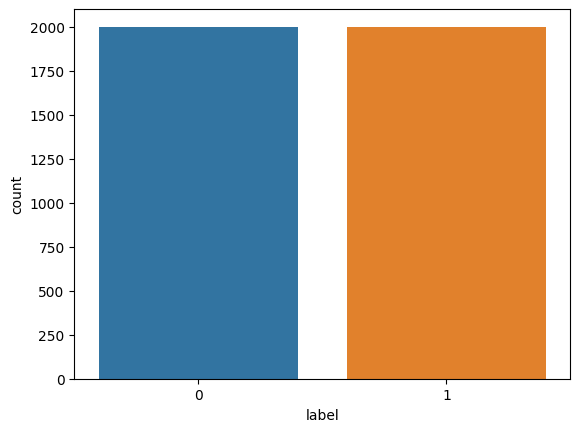

In [9]:
# Check for class balance
sns.countplot(data=balanced, x='label')
plt.show()


In [10]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

balanced['clean_text'] = balanced['final_text'].apply(clean_text)

In [11]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(balanced['clean_text'], balanced['label'], test_size=0.2, random_state=42)


<Axes: xlabel='label', ylabel='count'>

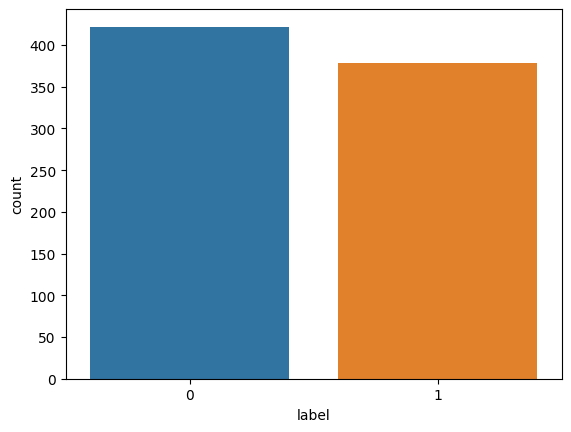

In [12]:
sns.countplot(x=y_val)

In [13]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# Paste your HF token here as a string:
login(token=secret_value_0)


In [14]:
# 1) Make sure transformers is installed/upgraded:
#    pip install --upgrade transformers huggingface-hub

from transformers import BertTokenizer, AutoTokenizer

try:
    # Try the direct BertTokenizer
    tokenizer = BertTokenizer.from_pretrained(
        "bert-base-uncased",
        do_lower_case=True,
        padding=True,
        truncation=True,
        max_length=128
    )
except OSError:
    # Fallback to AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        "bert-base-uncased",
        use_auth_token=True,   # if private
        do_lower_case=True,
        padding=True,
        truncation=True,
        max_length=128
    )

# Now you can tokenise:
example = "Hello, Transformers!"
enc = tokenizer(example, return_tensors="pt")
print(enc)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  7592,  1010, 19081,   999,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [15]:
# Tokenization and Encoding for BERTpip install --upgrade transformers huggingface-hub

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=128)


In [16]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')


In [17]:
# Convert labels to tensors
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)


In [18]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)


In [19]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [20]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [21]:
from transformers import BertForSequenceClassification
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4
)

# Move model to device
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5

In [23]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")


Epoch 1/5, Average Training Loss: 0.43
Epoch 2/5, Average Training Loss: 0.22
Epoch 3/5, Average Training Loss: 0.12
Epoch 4/5, Average Training Loss: 0.10
Epoch 5/5, Average Training Loss: 0.09


In [24]:
# Validation loop
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.extend(labels.cpu().numpy())


In [25]:
# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Validation Accuracy: 0.92


In [26]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, val_preds))


              precision    recall  f1-score   support

           0       0.90      0.95      0.93       422
           1       0.94      0.88      0.91       378

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



In [27]:
output_dir = "/kaggle/working/my_finetuned_bert"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('/kaggle/working/my_finetuned_bert/tokenizer_config.json',
 '/kaggle/working/my_finetuned_bert/special_tokens_map.json',
 '/kaggle/working/my_finetuned_bert/vocab.txt',
 '/kaggle/working/my_finetuned_bert/added_tokens.json')

In [30]:
bert   = AutoModel.from_pretrained("/kaggle/working/my_finetuned_bert").to(device)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/my_finetuned_bert")

bert.eval()
for p in bert.parameters():
    p.requires_grad = False

## Ganning

In [31]:
def encode(texts, max_len=128):
    toks = tokenizer(texts,
                     padding="max_length",
                     truncation=True,
                     max_length=max_len,
                     return_tensors="pt")
    for k,v in toks.items(): toks[k] = v.to(device)
    with torch.no_grad():
        out = bert(**toks, output_attentions=True)
    return out


In [42]:
from torch.utils.data import Dataset

class AttentionMapDataset(Dataset):
    def __init__(self, df, tokenizer, bert, max_len=64):
        """
        df:       pandas.DataFrame with columns ["final_text","label"],
                  already reset_index(drop=True)
        """
        # Ensure integer 0…N–1 indexing
        self.df        = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.bert      = bert
        self.max_len   = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Use iloc to grab by positional index
        row   = self.df.iloc[idx]
        text  = row["final_text"]
        label = row["label"]
        
        # 1) Tokenize
        toks = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        # put tokens on same device as BERT
        for k,v in toks.items():
            toks[k] = v.to(self.bert.device)

        # 2) Forward through BERT for attentions
        with torch.no_grad():
            out = self.bert(**toks, output_attentions=True)

        # 3) Aggregate attentions into one [L,L] map
        attn = torch.stack(out.attentions)      # [layers, 1, heads, L, L]
        attn = attn.mean(0).mean(1).squeeze(0)   # [L, L]

        # 4) Normalize [0,1] -> [-1,1], add channel dim
        attn = (2 * attn - 1).unsqueeze(0)      # [1, L, L]

        return attn, torch.tensor(label, dtype=torch.float32)


In [37]:
balanced = (
    df
    .groupby('label', group_keys=False)
    .sample(n=5000, random_state=40)
    .reset_index(drop=True)
)
balanced['clean_text'] = balanced['final_text'].apply(clean_text)

In [43]:
# 2) Split off 500 examples per class for validation
val_list = []
train_list = []
for label in balanced['label'].unique():
    subset = balanced[balanced['label'] == label]
    val_subset = subset.sample(n=500, random_state=42)
    train_subset = subset.drop(val_subset.index)
    val_list.append(val_subset)
    train_list.append(train_subset)

val_df = pd.concat(val_list).reset_index(drop=True)
train_df = pd.concat(train_list).reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")
# ➔ Train size: 9000 (4500 human + 4500 AI), Val size: 1000 (500 + 500)

# 3) Build Datasets & DataLoaders
train_ds = AttentionMapDataset(train_df, tokenizer, bert, max_len=64)
val_ds   = AttentionMapDataset(val_df,   tokenizer, bert, max_len=64)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, drop_last=False)

Train size: 9000, Val size: 1000


In [44]:
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_ch=1, ngf=64):
        super().__init__()
        # Encoder (downsamples by 2 each layer)
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch,    ngf, 4, 2, 1),
                                   nn.BatchNorm2d(ngf), nn.LeakyReLU(0.2))
        self.enc2 = nn.Sequential(nn.Conv2d(ngf,  ngf*2, 4, 2, 1),
                                   nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2))
        self.enc3 = nn.Sequential(nn.Conv2d(ngf*2,ngf*4, 4, 2, 1),
                                   nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2))
        self.enc4 = nn.Sequential(nn.Conv2d(ngf*4,ngf*8, 4, 2, 1),
                                   nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2))
        # Decoder (upsamples by 2 each layer, with skip-connections)
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(ngf*8,   ngf*4, 4, 2, 1),
                                   nn.BatchNorm2d(ngf*4), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(ngf*8,   ngf*2, 4, 2, 1),
                                   nn.BatchNorm2d(ngf*2), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(ngf*4,     ngf, 4, 2, 1),
                                   nn.BatchNorm2d(ngf),   nn.ReLU())
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(ngf*2, in_ch, 4, 2, 1),
                                   nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)              # → [B, ngf,    M/2,   M/2]
        e2 = self.enc2(e1)             # → [B,2ngf,   M/4,   M/4]
        e3 = self.enc3(e2)             # → [B,4ngf,   M/8,   M/8]
        e4 = self.enc4(e3)             # → [B,8ngf,   M/16,  M/16]
        d1 = self.dec1(e4)             
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        d4 = self.dec4(torch.cat([d3, e1], dim=1))
        return d4, d3  # d4: reconstructed matrix; d3: feature map


class Discriminator(nn.Module):
    def __init__(self, in_ch=1, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   ndf,   4, 2, 1), nn.BatchNorm2d(ndf),   nn.LeakyReLU(0.2),
            nn.Conv2d(ndf,    ndf*2,  4, 2, 1), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2),
            nn.Conv2d(ndf*2,  ndf*4,  4, 2, 1), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2),
            nn.Conv2d(ndf*4,     1,   4, 1, 0)                      # → [B,1,1,1]
        )

    def forward(self, x):
        return self.net(x).view(-1)  # flatten to [B]


In [47]:
import torch.autograd as autograd

def gradient_penalty(D, real, fake, device):
    B = real.size(0)
    alpha = torch.rand(B, 1, 1, 1, device=device)
    interp = (alpha * real + (1-alpha) * fake).requires_grad_(True)
    d_interp = D(interp)
    grads = autograd.grad(outputs=d_interp, inputs=interp,
                          grad_outputs=torch.ones_like(d_interp),
                          create_graph=True, retain_graph=True)[0]
    grads = grads.view(B, -1)
    return ((grads.norm(2, dim=1) - 1)**2).mean()



In [45]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = UNetGenerator(in_ch=1, ngf=64).to(device)
D = Discriminator(in_ch=1, ndf=64).to(device)

optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))

lambda_gp = 10    # WGAN-GP gradient penalty weight
lambda_l1 = 100   # L1 reconstruction loss weight
n_epochs  = 30    # start smaller; increase if needed

In [49]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# … (assume G, D, optG, optD, loader, gradient_penalty, lambda_gp, lambda_l1, device, n_epochs are defined) …

losses_D = []
losses_G = []

for epoch in range(1, n_epochs+1):
    epoch_lossD = 0.0
    epoch_lossG = 0.0
    n_batches   = 0

    for attn_map, labels in train_loader:
        # — select only human maps for GAN training —
        human_idx = (labels == 0).nonzero(as_tuple=True)[0]
        if human_idx.numel() == 0:
            continue
        real = attn_map[human_idx].to(device)

        # — Discriminator step —
        noisy_real = real + 0.01 * torch.randn_like(real)
        recon, _   = G(noisy_real)
        d_real     = D(real)
        d_fake     = D(recon.detach())
        gp         = gradient_penalty(D, real, recon.detach(), device)
        lossD      = -(d_real.mean() - d_fake.mean()) + lambda_gp * gp

        optD.zero_grad()
        lossD.backward()
        optD.step()

        # — Generator step —
        recon      = G(real)[0]
        lossG_adv  = -D(recon).mean()
        lossG_l1   = F.l1_loss(recon, real) * lambda_l1
        lossG      = lossG_adv + lossG_l1

        optG.zero_grad()
        lossG.backward()
        optG.step()

        epoch_lossD += lossD.item()
        epoch_lossG += lossG.item()
        n_batches   += 1

    # average losses for the epoch
    avgD = epoch_lossD / n_batches
    avgG = epoch_lossG / n_batches
    losses_D.append(avgD)
    losses_G.append(avgG)

    print(f"[Epoch {epoch}/{n_epochs}]  lossD: {avgD:.4f}  lossG: {avgG:.4f}")

    # checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save(G.state_dict(), f'G_epoch{epoch}.pth')
        torch.save(D.state_dict(), f'D_epoch{epoch}.pth')


[Epoch 1/30]  lossD: -16.1028  lossG: 9.8744
[Epoch 2/30]  lossD: -55.5771  lossG: 3.9427
[Epoch 3/30]  lossD: -78.6005  lossG: 1.6563
[Epoch 4/30]  lossD: 3420.9598  lossG: -9.4792
[Epoch 5/30]  lossD: 197.4570  lossG: -10.5207
[Epoch 6/30]  lossD: 1.3196  lossG: -10.8424
[Epoch 7/30]  lossD: -3.8174  lossG: -11.5816
[Epoch 8/30]  lossD: -0.5547  lossG: -11.7241
[Epoch 9/30]  lossD: 4.8200  lossG: -10.9057
[Epoch 10/30]  lossD: 0.0445  lossG: -10.2983
[Epoch 11/30]  lossD: 0.0185  lossG: -9.8354
[Epoch 12/30]  lossD: 0.0078  lossG: -9.2985
[Epoch 13/30]  lossD: 0.0038  lossG: -8.9091
[Epoch 14/30]  lossD: 0.0024  lossG: -8.5041
[Epoch 15/30]  lossD: 0.0014  lossG: -8.3121
[Epoch 16/30]  lossD: 0.0007  lossG: -8.0988
[Epoch 17/30]  lossD: 0.0001  lossG: -7.9673
[Epoch 18/30]  lossD: -0.0004  lossG: -7.8306
[Epoch 19/30]  lossD: -0.0006  lossG: -7.6680
[Epoch 20/30]  lossD: -0.0011  lossG: -7.5523
[Epoch 21/30]  lossD: -0.0013  lossG: -7.3801
[Epoch 22/30]  lossD: -0.0016  lossG: -7.246

KeyboardInterrupt: 

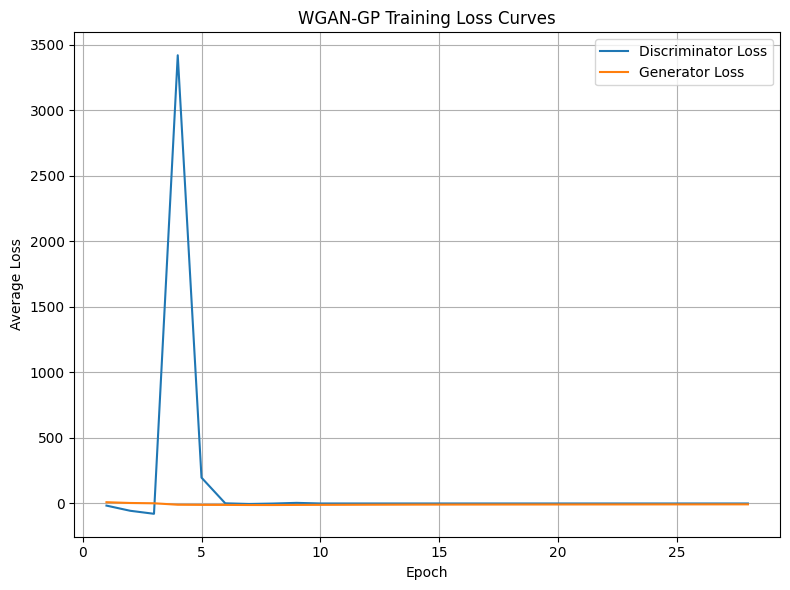

In [51]:

# — after training, plot the curves —
plt.figure(figsize=(8,6))
plt.plot(range(1, 29), losses_D, label='Discriminator Loss')
plt.plot(range(1, 29), losses_G, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('WGAN‑GP Training Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('gan_loss_curves.png')
plt.show()


In [53]:
torch.save(G.state_dict(), f'G_epoch{29}.pth')
torch.save(D.state_dict(), f'D_epoch{29}.pth')

## RFW

In [66]:
# collect them into a list of [B, 1, H, W] tensors
# train_ds = AttentionMapDataset(train_df, tokenizer, bert, max_len=64)
# val_ds   = AttentionMapDataset(val_df,   tokenizer, bert, max_len=64)

# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  drop_last=True)
# val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, drop_last=False)
feat_train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=False,   # no shuffling so order matches train_df.index
    drop_last=False  # keep every example
)

mat_list = []
for mats, _ in feat_train_loader:         # unpack the tuple
    # mats is a torch.Tensor of shape [B,1,H,W]
    mat_list.append(mats.cpu())      # optionally .cpu() if you're on GPU

# 3) Concatenate into one big tensor and convert to numpy
all_mats = torch.cat(mat_list, dim=0)    # shape: (N_train, 1, H, W)
matrices_sub = all_mats.squeeze(1).numpy()  # shape: (N_train, H, W)

print("Built matrices_sub shape:", matrices_sub.shape)

Built matrices_sub shape: (9000, 64, 64)


In [67]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# 4.1. Prepare an indexed dataset for matrices_sub
class IndexedMatrixDataset(Dataset):
    def __init__(self, matrices):
        # matrices: NumPy array of shape (N, M, M)
        self.mats = torch.from_numpy(matrices).float().unsqueeze(1)  # → (N,1,M,M)

    def __len__(self):
        return self.mats.size(0)

    def __getitem__(self, idx):
        return self.mats[idx], idx

# Create loader (no shuffle so idxs line up)
idx_ds = IndexedMatrixDataset(matrices_sub)
idx_loader = DataLoader(idx_ds, batch_size=16, shuffle=False, num_workers=2)

# 4.2. Ensure your Generator is in eval mode and on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.eval()
G.to(device)

# 4.3. Infer feat_dim from one batch
with torch.no_grad():
    sample_mats, sample_idxs = next(iter(idx_loader))
    sample_mats = sample_mats.to(device)
    _, sample_d3 = G(sample_mats)        # sample_d3 shape: [B, C, H, W]
    B, C, H, W = sample_d3.shape
    feat_dim = C * H * W
    print(f"Inferred feature dimension: C={C}, H={H}, W={W} → feat_dim={feat_dim}")

# 4.4. Allocate the features array
N = len(idx_ds)
features = np.zeros((N, feat_dim), dtype=np.float32)

# 4.5. Extract and store features
with torch.no_grad():
    for mats, idxs in tqdm(idx_loader, desc="Extracting GAN features"):
        mats = mats.to(device)
        _, d3 = G(mats)                     # d3: [B, C, H, W]
        flat = d3.view(d3.size(0), -1).cpu().numpy()  # → [B, feat_dim]
        for i, orig_idx in enumerate(idxs):
            features[orig_idx] = flat[i]

# Now `features` is an (N, feat_dim) array of your GAN-based representations
# You can proceed to Stage 5: Random Forest training with `features` and your labels.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Inferred feature dimension: C=64, H=32, W=32 → feat_dim=65536


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting GAN features:   0%|          | 0/563 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
y_train = train_df['label'].values
y_val   = val_df['label'].values

print("Training: X =", features.shape, "y =", y_train.shape)
# print("Validation: X =", val_feats.shape, "y =", y_val.shape)

# 2) Fit your Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(features, y_train)

Training: X = (9000, 65536) y = (9000,)


RandomForestClassifier(n_jobs=-1, random_state=42)

## doing validation

In [69]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report

# ─── A) Build a no‐shuffle, no‐drop loader for val_ds ─────────────────────────
feat_val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,   # preserve order vs. val_df.index
    drop_last=False
)

# ─── B) Collect all [B,1,H,W] tensors into one NumPy array ────────────────────
mat_list = []
for mats, _ in feat_val_loader:
    mat_list.append(mats.cpu())
all_val_mats   = torch.cat(mat_list, dim=0)         # (N_val,1,H,W)
matrices_val   = all_val_mats.squeeze(1).numpy()    # (N_val,H,W)
print("Built matrices_val shape:", matrices_val.shape)

# ─── C) Wrap in IndexedMatrixDataset and DataLoader ───────────────────────────
class IndexedMatrixDataset(Dataset):
    def __init__(self, matrices):
        self.mats = torch.from_numpy(matrices).float().unsqueeze(1)
    def __len__(self):
        return self.mats.size(0)
    def __getitem__(self, idx):
        return self.mats[idx], idx

val_idx_ds   = IndexedMatrixDataset(matrices_val)
val_idx_loader = DataLoader(val_idx_ds, batch_size=16, shuffle=False, num_workers=2)

# ─── D) Hook G and infer feat_dim (reuse from training) ────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.eval().to(device)

with torch.no_grad():
    sample_mats, _ = next(iter(val_idx_loader))
    sample_mats    = sample_mats.to(device)
    _, sample_d3   = G(sample_mats)
    B, C, H, W     = sample_d3.shape
    feat_dim       = C * H * W

# ─── E) Allocate val_features array ───────────────────────────────────────────
N_val      = len(val_idx_ds)
val_features = np.zeros((N_val, feat_dim), dtype=np.float32)

# ─── F) Extract & store validation features ──────────────────────────────────
with torch.no_grad():
    for mats, idxs in tqdm(val_idx_loader, desc="Extracting val features"):
        mats = mats.to(device)
        _, d3 = G(mats)  
        flat  = d3.view(d3.size(0), -1).cpu().numpy()
        for i, orig_idx in enumerate(idxs):
            val_features[orig_idx] = flat[i]

# ─── G) Run RF on val_features and print report ───────────────────────────────
y_val  = val_df['label'].values
y_pred = rf.predict(val_features)



Built matrices_val shape: (1000, 64, 64)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Extracting val features:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [70]:

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n",
      classification_report(y_val, y_pred, target_names=['human','AI']))

Validation Accuracy: 0.688

Classification Report:
               precision    recall  f1-score   support

       human       0.71      0.64      0.67       500
          AI       0.67      0.73      0.70       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000

